In [1]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
import torch.nn as nn
#from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models

import torchvision.transforms as transforms

In [3]:
from functions import(import_train_folder_dataset,
                      Data,
                      import_test_folder_dataset,
                      Data_test,
                      plot_loss_accuracy,
                      save_model,
                      save_metrics,
                      save_predictions_as_csv
                     )

# Variables

In [4]:
model_epochs = 100 # 100

lr = 0.006 # Learning rate.
                            
#torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 50 epochs

model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/CheckPoints/"
PATH = "D:\\Personal\\Alex\\Uni\\MS IA\\2 Curso\\Fall 2022\Artificial Intelligence\\Projects\\Project 1\\Models Save\\GoogleNet_CAM-Plus-ImgClass\\"

# Path of the Data files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped/Test"

cuda


# Import Data

In [5]:

img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((400, 400)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

## Train-Val data

In [6]:
# Import the data
train_data, train_labels = import_train_folder_dataset(train_data_path)
print("Train Dim of Data: ", train_data.shape)
print("Train Dim of Lables: ", train_labels.shape)

Train Dim of Data:  (1149, 400, 400, 3)
Train Dim of Lables:  (1149,)


In [7]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=1)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 400, 400, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 400, 400, 3)
Dim of y_test:  (115,)


In [8]:
# Create the dataset object
train_Dataset = Data(X_train, y_train, img_transform_val) # img_transform
val_Dataset = Data(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [9]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

## Test Data

In [10]:
# Import the data
test_data, test_names = import_test_folder_dataset(test_data_path)
print("Test Dim of Data: ", test_data.shape)
print("Test Dim of Lables: ", test_names.shape)

Test Dim of Data:  (380, 400, 400, 3)
Test Dim of Lables:  (380,)


In [11]:
# Create the dataset object
test_Dataset = Data_test(test_data, test_names, img_transform_val) # img_transform_2 img_transform

print("Test len: ",len(test_Dataset))

Test len:  380


In [12]:
# Create the dataloaders
test_loader = DataLoader(
    test_Dataset, 
    batch_size=1,             
    shuffle=False)

# Create Model

In [13]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self, googlenet):
        super(ClassificationNet, self).__init__()
        # get the pretrained googlenet network
        #self.googlenet = models.googlenet(pretrained=True)
        #self.resnet50 = models.resnet50(pretrained=True)
        
        # Get the feature extractor
        self.googlenet_fe = nn.Sequential(*list(googlenet.children())[:-1])
        #self.resnet50_fe = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Flatten the FE output
        self.flatten = nn.Flatten()
        
        # Add a clissifier
        #self.last_classifier =  nn.Linear(in_features=2048, out_features=4)
        self.last_classifier =  nn.Linear(in_features=1024, out_features=4)
        
    def forward(self, x): 
        #x = self.resnet50_fe(x)
        x = self.googlenet_fe(x)
        
        x = self.flatten(x)
        
        x = self.last_classifier(x)
        
        return x

modelpy = ClassificationNet(googlenet = models.googlenet(pretrained=True)).to(device)

# Loss Function
criterion_2 = nn.CrossEntropyLoss()

# Optimizer    
trainable_parameters_2 = filter(lambda p: p.requires_grad, modelpy.parameters())
#optimizer_2 = torch.optim.Adam(params=trainable_parameters_2, lr=lr)
optimizer_2 = torch.optim.SGD(params=trainable_parameters_2, lr=lr, momentum=1e-5) 

# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0

modelpy

D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ClassificationNet(
  (googlenet_fe): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (5): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0

In [14]:
# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt_m2.pth"):
        print("Loading saved checkpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt_m2.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optimizer_2.load_state_dict(checkpoint['optimizer_state_dict'])
        model_epoch_m2_check = checkpoint['epoch']
        criterion_2 = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {model_epoch_m2_check}")


# Train Model

In [15]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"]=lr

Epoch 1 of 100


100%|██████████| 15/15 [00:02<00:00,  6.66it/s]


train loss:  0.1455857887489422
Val loss:  0.13881908136865367
train accuracy:  0.42359767891682787
Val accuracy:  0.5217391304347826
Best model at the moment with Val_acc 52.17, saving...
Current time: 2.342 minutes. Time expected till completion: 231.878 minutes
Epoch 2 of 100


100%|██████████| 15/15 [00:02<00:00,  6.77it/s]


train loss:  0.13153601269196266
Val loss:  0.13040523114411728
train accuracy:  0.5502901353965184
Val accuracy:  0.5217391304347826
Current time: 3.217 minutes. Time expected till completion: 157.639 minutes
Epoch 3 of 100


100%|██████████| 15/15 [00:02<00:00,  6.91it/s]


train loss:  0.12449173758984534
Val loss:  0.1256933963817099
train accuracy:  0.5822050290135397
Val accuracy:  0.5565217391304348
Best model at the moment with Val_acc 55.65, saving...
Current time: 4.097 minutes. Time expected till completion: 132.463 minutes
Epoch 4 of 100


100%|██████████| 15/15 [00:02<00:00,  7.03it/s]


train loss:  0.12006824603394337
Val loss:  0.12264515109684156
train accuracy:  0.5870406189555126
Val accuracy:  0.5826086956521739
Best model at the moment with Val_acc 58.26, saving...
Current time: 4.975 minutes. Time expected till completion: 119.394 minutes
Epoch 5 of 100


100%|██████████| 15/15 [00:02<00:00,  6.68it/s]


train loss:  0.11685873421063968
Val loss:  0.12097892450249713
train accuracy:  0.5947775628626693
Val accuracy:  0.5652173913043478
Current time: 5.852 minutes. Time expected till completion: 111.187 minutes
Epoch 6 of 100


100%|██████████| 15/15 [00:02<00:00,  7.02it/s]


train loss:  0.11252837698740932
Val loss:  0.11975590560747229
train accuracy:  0.6102514506769826
Val accuracy:  0.6
Best model at the moment with Val_acc 60.0, saving...
Current time: 6.728 minutes. Time expected till completion: 105.402 minutes
Epoch 7 of 100


100%|██████████| 15/15 [00:02<00:00,  6.90it/s]


train loss:  0.11088610611985684
Val loss:  0.11683015564213628
train accuracy:  0.6063829787234043
Val accuracy:  0.5652173913043478
Current time: 7.601 minutes. Time expected till completion: 100.983 minutes
Epoch 8 of 100


100%|██████████| 15/15 [00:02<00:00,  6.98it/s]


train loss:  0.11082380272203073
Val loss:  0.12104201109512992
train accuracy:  0.6141199226305609
Val accuracy:  0.5565217391304348
Current time: 8.479 minutes. Time expected till completion: 97.510 minutes
Epoch 9 of 100


100%|██████████| 15/15 [00:02<00:00,  6.63it/s]


train loss:  0.11133601287347436
Val loss:  0.1138657958611198
train accuracy:  0.6170212765957447
Val accuracy:  0.5652173913043478
Current time: 9.358 minutes. Time expected till completion: 94.622 minutes
Epoch 10 of 100


100%|██████████| 15/15 [00:02<00:00,  6.85it/s]


train loss:  0.11057670509561579
Val loss:  0.11480568491894266
train accuracy:  0.620889748549323
Val accuracy:  0.5739130434782609
Current time: 10.234 minutes. Time expected till completion: 92.103 minutes
Epoch 11 of 100


100%|██████████| 15/15 [00:02<00:00,  6.86it/s]


train loss:  0.10673298976407522
Val loss:  0.11457834243774415
train accuracy:  0.6373307543520309
Val accuracy:  0.5652173913043478
Current time: 11.107 minutes. Time expected till completion: 89.864 minutes
Epoch 12 of 100


100%|██████████| 15/15 [00:02<00:00,  6.79it/s]


train loss:  0.10678366679748667
Val loss:  0.11157989346462747
train accuracy:  0.6247582205029013
Val accuracy:  0.5826086956521739
Current time: 11.982 minutes. Time expected till completion: 87.868 minutes
Epoch 13 of 100


100%|██████████| 15/15 [00:02<00:00,  6.92it/s]


train loss:  0.10662274163511781
Val loss:  0.1116034896477409
train accuracy:  0.6353965183752418
Val accuracy:  0.5826086956521739
Current time: 12.856 minutes. Time expected till completion: 86.034 minutes
Epoch 14 of 100


100%|██████████| 15/15 [00:02<00:00,  6.89it/s]


train loss:  0.10417821400977195
Val loss:  0.11364029956900555
train accuracy:  0.6373307543520309
Val accuracy:  0.591304347826087
Current time: 13.731 minutes. Time expected till completion: 84.350 minutes
Epoch 15 of 100


100%|██████████| 15/15 [00:02<00:00,  6.95it/s]


train loss:  0.1062379457503269
Val loss:  0.11013151718222576
train accuracy:  0.6363636363636364
Val accuracy:  0.6260869565217392
Best model at the moment with Val_acc 62.61, saving...
Current time: 14.609 minutes. Time expected till completion: 82.784 minutes
Epoch 16 of 100


100%|██████████| 15/15 [00:02<00:00,  6.59it/s]


train loss:  0.10113291471216619
Val loss:  0.11194414315016374
train accuracy:  0.6431334622823984
Val accuracy:  0.5565217391304348
Current time: 15.485 minutes. Time expected till completion: 81.295 minutes
Epoch 17 of 100


100%|██████████| 15/15 [00:02<00:00,  6.92it/s]


train loss:  0.1030672709646723
Val loss:  0.10840523450270943
train accuracy:  0.6547388781431335
Val accuracy:  0.5652173913043478
Current time: 16.360 minutes. Time expected till completion: 79.875 minutes
Epoch 18 of 100


100%|██████████| 15/15 [00:02<00:00,  6.92it/s]


train loss:  0.10117166170875616
Val loss:  0.10890637947165448
train accuracy:  0.6615087040618955
Val accuracy:  0.6
Current time: 17.234 minutes. Time expected till completion: 78.510 minutes
Epoch 19 of 100


100%|██████████| 15/15 [00:02<00:00,  6.67it/s]


train loss:  0.10132088594325968
Val loss:  0.10610580703486568
train accuracy:  0.6421663442940039
Val accuracy:  0.6173913043478261
Current time: 18.112 minutes. Time expected till completion: 77.216 minutes
Epoch 20 of 100


100%|██████████| 15/15 [00:02<00:00,  6.91it/s]


train loss:  0.10060175867099135
Val loss:  0.11060047460638958
train accuracy:  0.6450676982591876
Val accuracy:  0.6173913043478261
Current time: 18.991 minutes. Time expected till completion: 75.963 minutes
Epoch 21 of 100


100%|██████████| 15/15 [00:02<00:00,  6.85it/s]


train loss:  0.0992073057871492
Val loss:  0.1091710028441056
train accuracy:  0.648936170212766
Val accuracy:  0.6434782608695652
Best model at the moment with Val_acc 64.35, saving...
Current time: 19.874 minutes. Time expected till completion: 74.764 minutes
Epoch 22 of 100


100%|██████████| 15/15 [00:02<00:00,  6.78it/s]


train loss:  0.09659611625413138
Val loss:  0.10883986068808514
train accuracy:  0.6808510638297872
Val accuracy:  0.6086956521739131
Current time: 20.758 minutes. Time expected till completion: 73.595 minutes
Epoch 23 of 100


100%|██████████| 15/15 [00:02<00:00,  6.71it/s]


train loss:  0.09998173533256095
Val loss:  0.10990990244823953
train accuracy:  0.6566731141199227
Val accuracy:  0.6173913043478261
Current time: 21.640 minutes. Time expected till completion: 72.448 minutes
Epoch 24 of 100


100%|██████████| 15/15 [00:02<00:00,  6.84it/s]


train loss:  0.0954450823121652
Val loss:  0.10781750005224476
train accuracy:  0.6692456479690522
Val accuracy:  0.5826086956521739
Current time: 22.525 minutes. Time expected till completion: 71.329 minutes
Epoch 25 of 100


100%|██████████| 15/15 [00:02<00:00,  6.68it/s]


train loss:  0.09685582432686937
Val loss:  0.10820916528287142
train accuracy:  0.6789168278529981
Val accuracy:  0.6086956521739131
Current time: 23.407 minutes. Time expected till completion: 70.222 minutes
Epoch 26 of 100


100%|██████████| 15/15 [00:02<00:00,  6.60it/s]


train loss:  0.09580027209720944
Val loss:  0.10853016428325488
train accuracy:  0.6789168278529981
Val accuracy:  0.591304347826087
Current time: 24.293 minutes. Time expected till completion: 69.142 minutes
Epoch 27 of 100


100%|██████████| 15/15 [00:02<00:00,  6.86it/s]


train loss:  0.09792339660558756
Val loss:  0.10958949068318243
train accuracy:  0.6692456479690522
Val accuracy:  0.5826086956521739
Current time: 25.177 minutes. Time expected till completion: 68.070 minutes
Epoch 28 of 100


100%|██████████| 15/15 [00:02<00:00,  6.75it/s]


train loss:  0.09303245403780466
Val loss:  0.1073551955430404
train accuracy:  0.688588007736944
Val accuracy:  0.6173913043478261
Current time: 26.061 minutes. Time expected till completion: 67.014 minutes
Epoch 29 of 100


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.09427070859783623
Val loss:  0.10522845413373864
train accuracy:  0.6808510638297872
Val accuracy:  0.6260869565217392
Current time: 26.952 minutes. Time expected till completion: 65.987 minutes
Epoch 30 of 100


100%|██████████| 15/15 [00:02<00:00,  6.89it/s]


train loss:  0.09129915598282731
Val loss:  0.11016319031300752
train accuracy:  0.7021276595744681
Val accuracy:  0.6347826086956522
Current time: 27.838 minutes. Time expected till completion: 64.955 minutes
Epoch 31 of 100


100%|██████████| 15/15 [00:02<00:00,  6.87it/s]


train loss:  0.0910417871329955
Val loss:  0.10552174552627232
train accuracy:  0.6876208897485493
Val accuracy:  0.6086956521739131
Current time: 28.726 minutes. Time expected till completion: 63.938 minutes
Epoch 32 of 100


100%|██████████| 15/15 [00:02<00:00,  6.55it/s]


train loss:  0.08989353420310141
Val loss:  0.11108146646748418
train accuracy:  0.6963249516441006
Val accuracy:  0.6521739130434783
Best model at the moment with Val_acc 65.22, saving...
Current time: 29.616 minutes. Time expected till completion: 62.934 minutes
Epoch 33 of 100


100%|██████████| 15/15 [00:02<00:00,  6.74it/s]


train loss:  0.09165383690906909
Val loss:  0.10812579082406086
train accuracy:  0.6760154738878144
Val accuracy:  0.6
Current time: 30.505 minutes. Time expected till completion: 61.935 minutes
Epoch 34 of 100


100%|██████████| 15/15 [00:02<00:00,  6.87it/s]


train loss:  0.08979061995299688
Val loss:  0.10618644408557726
train accuracy:  0.7021276595744681
Val accuracy:  0.6173913043478261
Current time: 31.392 minutes. Time expected till completion: 60.938 minutes
Epoch 35 of 100


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.0880763780909304
Val loss:  0.10664503652116526
train accuracy:  0.690522243713733
Val accuracy:  0.5826086956521739
Current time: 32.283 minutes. Time expected till completion: 59.954 minutes
Epoch 36 of 100


100%|██████████| 15/15 [00:02<00:00,  6.85it/s]


train loss:  0.08859046348289548
Val loss:  0.10666454149329144
train accuracy:  0.7117988394584139
Val accuracy:  0.6086956521739131
Current time: 33.172 minutes. Time expected till completion: 58.972 minutes
Epoch 37 of 100


100%|██████████| 15/15 [00:02<00:00,  6.81it/s]


train loss:  0.08835030164086842
Val loss:  0.10434312094812807
train accuracy:  0.706963249516441
Val accuracy:  0.6434782608695652
Current time: 34.061 minutes. Time expected till completion: 57.995 minutes
Epoch 38 of 100


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.08618301303059266
Val loss:  0.10346883198489314
train accuracy:  0.7166344294003868
Val accuracy:  0.6260869565217392
Current time: 34.950 minutes. Time expected till completion: 57.023 minutes
Epoch 39 of 100


100%|██████████| 15/15 [00:02<00:00,  6.82it/s]


train loss:  0.0858681228163164
Val loss:  0.10352099175038545
train accuracy:  0.7147001934235977
Val accuracy:  0.6260869565217392
Current time: 35.838 minutes. Time expected till completion: 56.055 minutes
Epoch 40 of 100


100%|██████████| 15/15 [00:02<00:00,  6.88it/s]


train loss:  0.08263281238494113
Val loss:  0.10509372794109842
train accuracy:  0.7263056092843327
Val accuracy:  0.6260869565217392
Current time: 36.727 minutes. Time expected till completion: 55.091 minutes
Epoch 41 of 100


100%|██████████| 15/15 [00:02<00:00,  6.52it/s]


train loss:  0.08351935434733415
Val loss:  0.10984071441318678
train accuracy:  0.7156673114119922
Val accuracy:  0.6086956521739131
Current time: 37.618 minutes. Time expected till completion: 54.133 minutes
Epoch 42 of 100


100%|██████████| 15/15 [00:02<00:00,  6.80it/s]


train loss:  0.08550574124666431
Val loss:  0.10672409793604976
train accuracy:  0.7263056092843327
Val accuracy:  0.6
Current time: 38.509 minutes. Time expected till completion: 53.179 minutes
Epoch 43 of 100


100%|██████████| 15/15 [00:02<00:00,  6.76it/s]


train loss:  0.08335075440962494
Val loss:  0.10189650680707849
train accuracy:  0.730174081237911
Val accuracy:  0.6521739130434783
Current time: 39.400 minutes. Time expected till completion: 52.228 minutes
Epoch 44 of 100


100%|██████████| 15/15 [00:02<00:00,  6.55it/s]


train loss:  0.07934949392852746
Val loss:  0.10708569055018217
train accuracy:  0.7408123791102514
Val accuracy:  0.6260869565217392
Current time: 40.292 minutes. Time expected till completion: 51.281 minutes
Epoch 45 of 100


100%|██████████| 15/15 [00:02<00:00,  6.81it/s]


train loss:  0.07831798354073696
Val loss:  0.1063116571177607
train accuracy:  0.7620889748549323
Val accuracy:  0.6086956521739131
Current time: 41.188 minutes. Time expected till completion: 50.341 minutes
Epoch 46 of 100


100%|██████████| 15/15 [00:02<00:00,  6.81it/s]


train loss:  0.07581628622699753
Val loss:  0.10540789806324502
train accuracy:  0.7553191489361702
Val accuracy:  0.6434782608695652
Current time: 42.080 minutes. Time expected till completion: 49.399 minutes
Epoch 47 of 100


100%|██████████| 15/15 [00:02<00:00,  6.64it/s]


train loss:  0.07842480293267931
Val loss:  0.10904205804285796
train accuracy:  0.7379110251450677
Val accuracy:  0.6173913043478261
Current time: 42.972 minutes. Time expected till completion: 48.457 minutes
Epoch 48 of 100


100%|██████████| 15/15 [00:02<00:00,  6.92it/s]


train loss:  0.08074093950152167
Val loss:  0.10566859478535859
train accuracy:  0.7504835589941973
Val accuracy:  0.6608695652173913
Best model at the moment with Val_acc 66.09, saving...
Current time: 43.862 minutes. Time expected till completion: 47.517 minutes
Epoch 49 of 100


100%|██████████| 15/15 [00:02<00:00,  6.84it/s]


train loss:  0.08123002029825686
Val loss:  0.10525837566541589
train accuracy:  0.7408123791102514
Val accuracy:  0.6521739130434783
Current time: 44.749 minutes. Time expected till completion: 46.576 minutes
Epoch 50 of 100


100%|██████████| 15/15 [00:02<00:00,  6.23it/s]


train loss:  0.07629450890496806
Val loss:  0.10661455289177273
train accuracy:  0.7630560928433269
Val accuracy:  0.6608695652173913
Current time: 45.645 minutes. Time expected till completion: 45.645 minutes
Epoch 51 of 100


100%|██████████| 15/15 [00:02<00:00,  6.85it/s]


train loss:  0.07124676026504782
Val loss:  0.11204379097275112
train accuracy:  0.7611218568665378
Val accuracy:  0.6173913043478261
Current time: 46.532 minutes. Time expected till completion: 44.707 minutes
Epoch 52 of 100


100%|██████████| 15/15 [00:02<00:00,  6.78it/s]


train loss:  0.07482335239475885
Val loss:  0.11282929182052612
train accuracy:  0.7562862669245648
Val accuracy:  0.6086956521739131
Current time: 47.422 minutes. Time expected till completion: 43.774 minutes
Epoch 53 of 100


100%|██████████| 15/15 [00:02<00:00,  6.76it/s]


train loss:  0.0718322985551574
Val loss:  0.109539962074031
train accuracy:  0.7756286266924565
Val accuracy:  0.6173913043478261
Current time: 48.315 minutes. Time expected till completion: 42.846 minutes
Epoch 54 of 100


100%|██████████| 15/15 [00:02<00:00,  6.87it/s]


train loss:  0.07122991651988353
Val loss:  0.11111670965733736
train accuracy:  0.7872340425531915
Val accuracy:  0.6260869565217392
Current time: 49.210 minutes. Time expected till completion: 41.919 minutes
Epoch 55 of 100


100%|██████████| 15/15 [00:02<00:00,  6.29it/s]


train loss:  0.07225794706861101
Val loss:  0.1125368525152621
train accuracy:  0.7678916827852998
Val accuracy:  0.6347826086956522
Current time: 50.108 minutes. Time expected till completion: 40.997 minutes
Epoch 56 of 100


100%|██████████| 15/15 [00:02<00:00,  6.87it/s]


train loss:  0.06926138802815221
Val loss:  0.10689109563827515
train accuracy:  0.7891682785299806
Val accuracy:  0.6086956521739131
Current time: 50.998 minutes. Time expected till completion: 40.070 minutes
Epoch 57 of 100


100%|██████████| 15/15 [00:02<00:00,  6.83it/s]


train loss:  0.07148872657428627
Val loss:  0.10586695023204969
train accuracy:  0.7804642166344294
Val accuracy:  0.6347826086956522
Current time: 51.887 minutes. Time expected till completion: 39.143 minutes
Epoch 58 of 100


100%|██████████| 15/15 [00:02<00:00,  6.57it/s]


train loss:  0.06612403597142295
Val loss:  0.11136292918868687
train accuracy:  0.7911025145067698
Val accuracy:  0.6260869565217392
Current time: 52.781 minutes. Time expected till completion: 38.221 minutes
Epoch 59 of 100


100%|██████████| 15/15 [00:02<00:00,  6.59it/s]


train loss:  0.06555450405039225
Val loss:  0.11356165694153827
train accuracy:  0.804642166344294
Val accuracy:  0.6260869565217392
Current time: 53.679 minutes. Time expected till completion: 37.302 minutes
Epoch 60 of 100


100%|██████████| 15/15 [00:02<00:00,  6.65it/s]


train loss:  0.06456427294869026
Val loss:  0.11200104407642199
train accuracy:  0.793036750483559
Val accuracy:  0.6173913043478261
Current time: 54.580 minutes. Time expected till completion: 36.387 minutes
Epoch 61 of 100


100%|██████████| 15/15 [00:02<00:00,  6.56it/s]


train loss:  0.06371747071150424
Val loss:  0.11024338628934777
train accuracy:  0.8133462282398453
Val accuracy:  0.6260869565217392
Current time: 55.496 minutes. Time expected till completion: 35.481 minutes
Epoch 62 of 100


100%|██████████| 15/15 [00:02<00:00,  6.74it/s]


train loss:  0.0656082474949051
Val loss:  0.11179331826127094
train accuracy:  0.7978723404255319
Val accuracy:  0.6
Current time: 56.402 minutes. Time expected till completion: 34.569 minutes
Epoch 63 of 100


100%|██████████| 15/15 [00:02<00:00,  6.25it/s]


train loss:  0.06219032863641385
Val loss:  0.11359886190165644
train accuracy:  0.8201160541586073
Val accuracy:  0.6347826086956522
Current time: 57.320 minutes. Time expected till completion: 33.664 minutes
Epoch 64 of 100


100%|██████████| 15/15 [00:02<00:00,  5.97it/s]


train loss:  0.060560750704784685
Val loss:  0.11276540315669516
train accuracy:  0.811411992263056
Val accuracy:  0.6260869565217392
Current time: 58.228 minutes. Time expected till completion: 32.753 minutes
Epoch 65 of 100


100%|██████████| 15/15 [00:02<00:00,  6.81it/s]


train loss:  0.06233719491347584
Val loss:  0.10879223994586779
train accuracy:  0.8065764023210832
Val accuracy:  0.6347826086956522
Current time: 59.141 minutes. Time expected till completion: 31.845 minutes
Epoch 66 of 100


100%|██████████| 15/15 [00:02<00:00,  5.32it/s]


train loss:  0.06000444493337572
Val loss:  0.1135765702828117
train accuracy:  0.8307543520309478
Val accuracy:  0.6173913043478261
Current time: 60.062 minutes. Time expected till completion: 30.941 minutes
Epoch 67 of 100


100%|██████████| 15/15 [00:02<00:00,  6.57it/s]


train loss:  0.062353532826185686
Val loss:  0.11366668758185014
train accuracy:  0.8104448742746615
Val accuracy:  0.6
Current time: 60.971 minutes. Time expected till completion: 30.031 minutes
Epoch 68 of 100


100%|██████████| 15/15 [00:02<00:00,  6.41it/s]


train loss:  0.057542438188304755
Val loss:  0.11779262501260508
train accuracy:  0.8288201160541586
Val accuracy:  0.6434782608695652
Current time: 61.879 minutes. Time expected till completion: 29.120 minutes
Epoch 69 of 100


100%|██████████| 15/15 [00:02<00:00,  6.92it/s]


train loss:  0.058021307957126275
Val loss:  0.12111310932947242
train accuracy:  0.8491295938104448
Val accuracy:  0.6434782608695652
Current time: 62.788 minutes. Time expected till completion: 28.209 minutes
Epoch 70 of 100


100%|██████████| 15/15 [00:02<00:00,  6.84it/s]


train loss:  0.055646911753446035
Val loss:  0.11458586091580598
train accuracy:  0.844294003868472
Val accuracy:  0.6086956521739131
Current time: 63.680 minutes. Time expected till completion: 27.291 minutes
Epoch 71 of 100


100%|██████████| 15/15 [00:02<00:00,  6.70it/s]


train loss:  0.05517039745613731
Val loss:  0.11673983439155247
train accuracy:  0.8529980657640233
Val accuracy:  0.6260869565217392
Current time: 64.581 minutes. Time expected till completion: 26.378 minutes
Epoch 72 of 100


100%|██████████| 15/15 [00:02<00:00,  6.90it/s]


train loss:  0.054484885978571915
Val loss:  0.12235204707021298
train accuracy:  0.844294003868472
Val accuracy:  0.591304347826087
Current time: 65.473 minutes. Time expected till completion: 25.462 minutes
Epoch 73 of 100


100%|██████████| 15/15 [00:02<00:00,  6.73it/s]


train loss:  0.05336802712924476
Val loss:  0.11874040792817654
train accuracy:  0.844294003868472
Val accuracy:  0.6086956521739131
Current time: 66.370 minutes. Time expected till completion: 24.548 minutes
Epoch 74 of 100


100%|██████████| 15/15 [00:02<00:00,  6.28it/s]


train loss:  0.05102598265793384
Val loss:  0.12960132982419884
train accuracy:  0.8694390715667312
Val accuracy:  0.6
Current time: 67.274 minutes. Time expected till completion: 23.637 minutes
Epoch 75 of 100


100%|██████████| 15/15 [00:02<00:00,  6.81it/s]


train loss:  0.05210909436184848
Val loss:  0.11788123923799267
train accuracy:  0.8617021276595744
Val accuracy:  0.5826086956521739
Current time: 68.188 minutes. Time expected till completion: 22.729 minutes
Epoch 76 of 100


100%|██████████| 15/15 [00:02<00:00,  6.35it/s]


train loss:  0.047566602838800306
Val loss:  0.1253250531528307
train accuracy:  0.874274661508704
Val accuracy:  0.591304347826087
Current time: 69.102 minutes. Time expected till completion: 21.822 minutes
Epoch 77 of 100


100%|██████████| 15/15 [00:02<00:00,  5.88it/s]


train loss:  0.044954774011380434
Val loss:  0.13129935627398284
train accuracy:  0.8907156673114119
Val accuracy:  0.6086956521739131
Current time: 70.016 minutes. Time expected till completion: 20.914 minutes
Epoch 78 of 100


100%|██████████| 15/15 [00:02<00:00,  6.56it/s]


train loss:  0.048046670537045665
Val loss:  0.1259008324664572
train accuracy:  0.8636363636363636
Val accuracy:  0.6
Current time: 70.918 minutes. Time expected till completion: 20.003 minutes
Epoch 79 of 100


100%|██████████| 15/15 [00:02<00:00,  6.86it/s]


train loss:  0.04985171998896036
Val loss:  0.12834686455519304
train accuracy:  0.8471953578336557
Val accuracy:  0.6086956521739131
Current time: 71.809 minutes. Time expected till completion: 19.089 minutes
Epoch 80 of 100


100%|██████████| 15/15 [00:02<00:00,  6.93it/s]


train loss:  0.04401605110075073
Val loss:  0.1314365143361299
train accuracy:  0.8820116054158608
Val accuracy:  0.6173913043478261
Current time: 72.703 minutes. Time expected till completion: 18.176 minutes
Epoch 81 of 100


100%|██████████| 15/15 [00:02<00:00,  6.39it/s]


train loss:  0.04455994620803938
Val loss:  0.1292002418766851
train accuracy:  0.8733075435203095
Val accuracy:  0.6260869565217392
Current time: 73.598 minutes. Time expected till completion: 17.264 minutes
Epoch 82 of 100


100%|██████████| 15/15 [00:02<00:00,  6.89it/s]


train loss:  0.041672593807689916
Val loss:  0.12654930897380995
train accuracy:  0.8916827852998066
Val accuracy:  0.6260869565217392
Current time: 74.492 minutes. Time expected till completion: 16.352 minutes
Epoch 83 of 100


100%|██████████| 15/15 [00:02<00:00,  6.89it/s]


train loss:  0.04425356460724394
Val loss:  0.13481732218161874
train accuracy:  0.8762088974854932
Val accuracy:  0.6347826086956522
Current time: 75.387 minutes. Time expected till completion: 15.441 minutes
Epoch 84 of 100


100%|██████████| 15/15 [00:02<00:00,  6.14it/s]


train loss:  0.04422519668734973
Val loss:  0.13726120539333508
train accuracy:  0.8713733075435203
Val accuracy:  0.591304347826087
Current time: 76.299 minutes. Time expected till completion: 14.533 minutes
Epoch 85 of 100


100%|██████████| 15/15 [00:02<00:00,  6.73it/s]


train loss:  0.043555853466865406
Val loss:  0.12810949190803197
train accuracy:  0.8810444874274661
Val accuracy:  0.6347826086956522
Current time: 77.196 minutes. Time expected till completion: 13.623 minutes
Epoch 86 of 100


100%|██████████| 15/15 [00:02<00:00,  6.34it/s]


train loss:  0.04344048974333003
Val loss:  0.13039912711019103
train accuracy:  0.8771760154738878
Val accuracy:  0.6260869565217392
Current time: 78.104 minutes. Time expected till completion: 12.715 minutes
Epoch 87 of 100


100%|██████████| 15/15 [00:02<00:00,  6.66it/s]


train loss:  0.0378327180002771
Val loss:  0.13331008009288622
train accuracy:  0.8974854932301741
Val accuracy:  0.5826086956521739
Current time: 79.017 minutes. Time expected till completion: 11.807 minutes
Epoch 88 of 100


100%|██████████| 15/15 [00:02<00:00,  6.61it/s]


train loss:  0.041996186822508705
Val loss:  0.1324504528356635
train accuracy:  0.9042553191489362
Val accuracy:  0.6347826086956522
Current time: 79.934 minutes. Time expected till completion: 10.900 minutes
Epoch 89 of 100


100%|██████████| 15/15 [00:02<00:00,  6.39it/s]


train loss:  0.0391436832627314
Val loss:  0.13748312981232352
train accuracy:  0.9032882011605415
Val accuracy:  0.6086956521739131
Current time: 80.831 minutes. Time expected till completion: 9.990 minutes
Epoch 90 of 100


100%|██████████| 15/15 [00:02<00:00,  6.89it/s]


train loss:  0.03437125452972473
Val loss:  0.13111450879470163
train accuracy:  0.913926499032882
Val accuracy:  0.6086956521739131
Current time: 81.737 minutes. Time expected till completion: 9.082 minutes
Epoch 91 of 100


100%|██████████| 15/15 [00:02<00:00,  6.27it/s]


train loss:  0.03893555906138291
Val loss:  0.13619674858839614
train accuracy:  0.8984526112185687
Val accuracy:  0.591304347826087
Current time: 82.665 minutes. Time expected till completion: 8.176 minutes
Epoch 92 of 100


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.03496234020942415
Val loss:  0.14074912045312965
train accuracy:  0.9168278529980658
Val accuracy:  0.6347826086956522
Current time: 83.575 minutes. Time expected till completion: 7.267 minutes
Epoch 93 of 100


100%|██████████| 15/15 [00:02<00:00,  5.97it/s]


train loss:  0.03786191856218376
Val loss:  0.13988467299419902
train accuracy:  0.9052224371373307
Val accuracy:  0.591304347826087
Current time: 84.496 minutes. Time expected till completion: 6.360 minutes
Epoch 94 of 100


100%|██████████| 15/15 [00:02<00:00,  6.87it/s]


train loss:  0.039719003142799816
Val loss:  0.1334222428176714
train accuracy:  0.8926499032882012
Val accuracy:  0.6434782608695652
Current time: 85.399 minutes. Time expected till completion: 5.451 minutes
Epoch 95 of 100


100%|██████████| 15/15 [00:02<00:00,  6.91it/s]


train loss:  0.03296270456734317
Val loss:  0.13718014229898867
train accuracy:  0.9081237911025145
Val accuracy:  0.6260869565217392
Current time: 86.288 minutes. Time expected till completion: 4.541 minutes
Epoch 96 of 100


100%|██████████| 15/15 [00:02<00:00,  6.69it/s]


train loss:  0.0333554243103275
Val loss:  0.13696952799092169
train accuracy:  0.9100580270793037
Val accuracy:  0.6173913043478261
Current time: 87.175 minutes. Time expected till completion: 3.632 minutes
Epoch 97 of 100


100%|██████████| 15/15 [00:02<00:00,  6.83it/s]


train loss:  0.03585862043733408
Val loss:  0.14830287720846094
train accuracy:  0.9119922630560928
Val accuracy:  0.6086956521739131
Current time: 88.064 minutes. Time expected till completion: 2.724 minutes
Epoch 98 of 100


100%|██████████| 15/15 [00:02<00:00,  6.57it/s]


train loss:  0.032968451674285436
Val loss:  0.16457724078841832
train accuracy:  0.9216634429400387
Val accuracy:  0.5652173913043478
Current time: 88.953 minutes. Time expected till completion: 1.815 minutes
Epoch 99 of 100


100%|██████████| 15/15 [00:02<00:00,  6.71it/s]


train loss:  0.032797262267114116
Val loss:  0.16544409186943718
train accuracy:  0.9264990328820116
Val accuracy:  0.6260869565217392
Current time: 89.841 minutes. Time expected till completion: 0.907 minutes
Epoch 100 of 100


100%|██████████| 15/15 [00:02<00:00,  6.82it/s]


train loss:  0.03269733367145523
Val loss:  0.16224644883819248
train accuracy:  0.9235976789168279
Val accuracy:  0.5739130434782609
Saving model 2 checkpoint


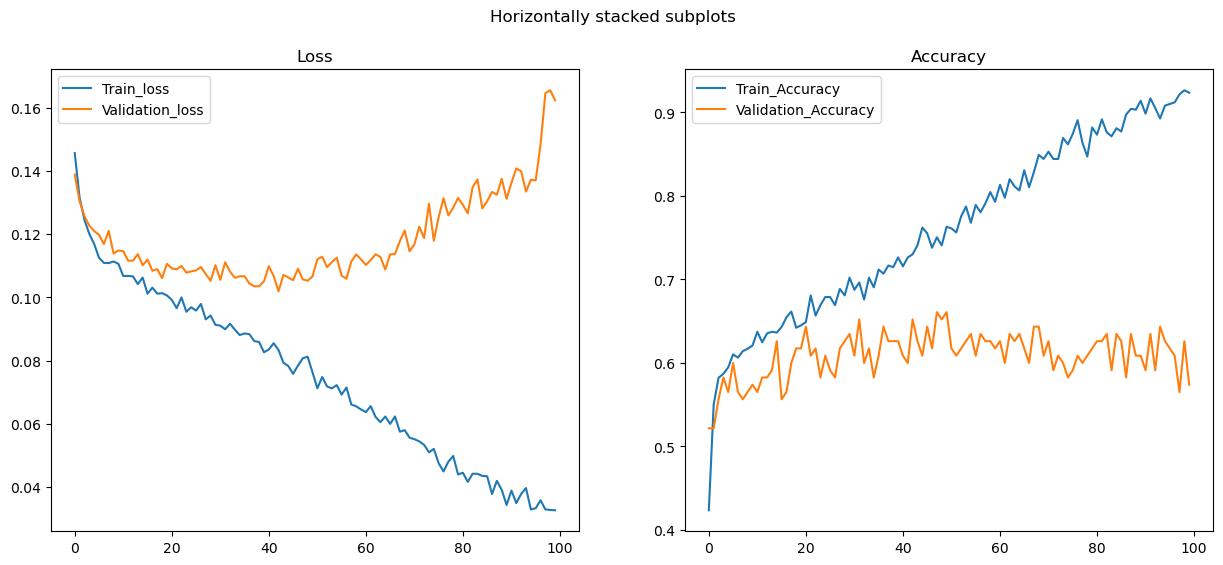

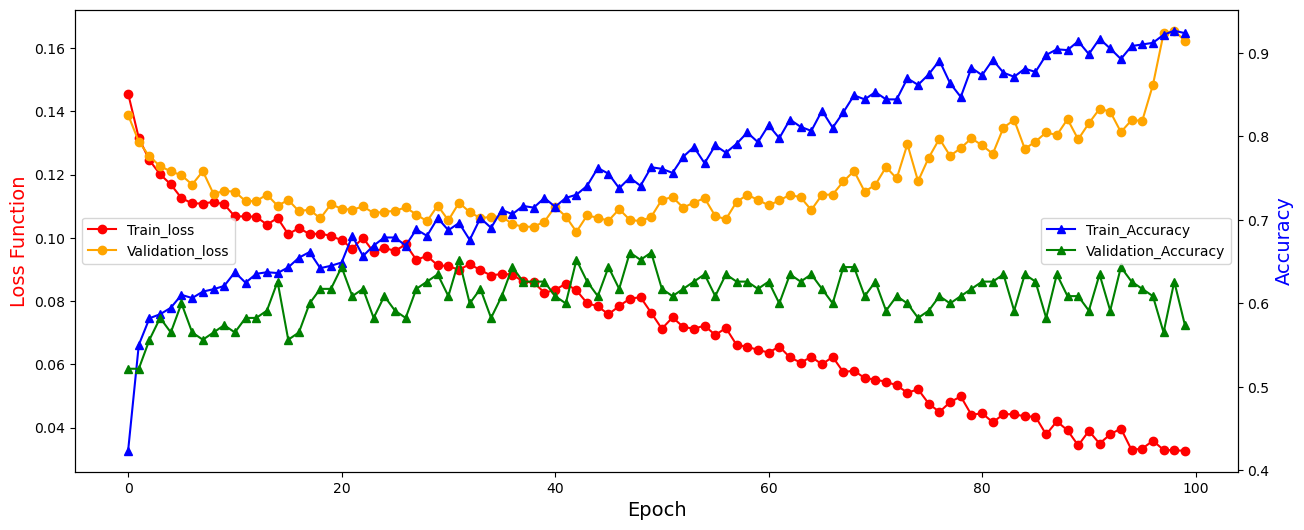

Current time: 90.876 minutes. Time expected till completion: 0.000 minutes
Finished training in: 90.876 minutes


In [16]:

best_model_val_acc = -1

train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy_m2.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy_m2.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()

# count time
start = time.time()
for epoch in range(model_epoch_m2_check, model_epochs):
    # Print current epoch
    print(f"Epoch {epoch + 1} of {model_epochs}")
    
    if(epoch%10 == 0):
        update_optimizer(optimizer_2, 0.001)
        
    ############################################################################
    ################################ Train model ############################### 
    ############################################################################
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # Optimize second model
        
        #create the output from the CNN base on the give batch images
        out_m2 = modelpy(images)
        # count the loss function 
        loss_2 = criterion_2(out_m2, labels)    
        
        # BackPropagate on model 2
        ######################
        optimizer_2.zero_grad()
        ######################
        # count the backpropagation
        loss_2.backward()
        # learning
        optimizer_2.step()
        
        
        
        # add new value to the main loss
        running_loss += loss_2.item()
        
        # calculate accuracy
        predictions = torch.argmax(out_m2, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    ############################################################################
    ################################ Eval model ################################ 
    ############################################################################
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion_2(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total
    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)
    
    # Save best model
    if(best_model_val_acc < val_epoch_accuracy):
        print(f"Best model at the moment with Val_acc {round(val_epoch_accuracy*100,2)}, saving...")
        # Save Model
        bestmodel_name = "model_2_bestModel.pt"
        torch.save(modelpy, PATH+bestmodel_name)
        best_model_val_acc = val_epoch_accuracy
    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        
        end = time.time()
        time_elapsed = (end-start)+previous_time
        
        # Save Model
        print("Saving model 2 checkpoint")
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy_m2.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2_"+str(epoch+1)+".pth")
        
        
        # Check the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (model_epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

In [17]:
best_model_val_acc

0.6608695652173913

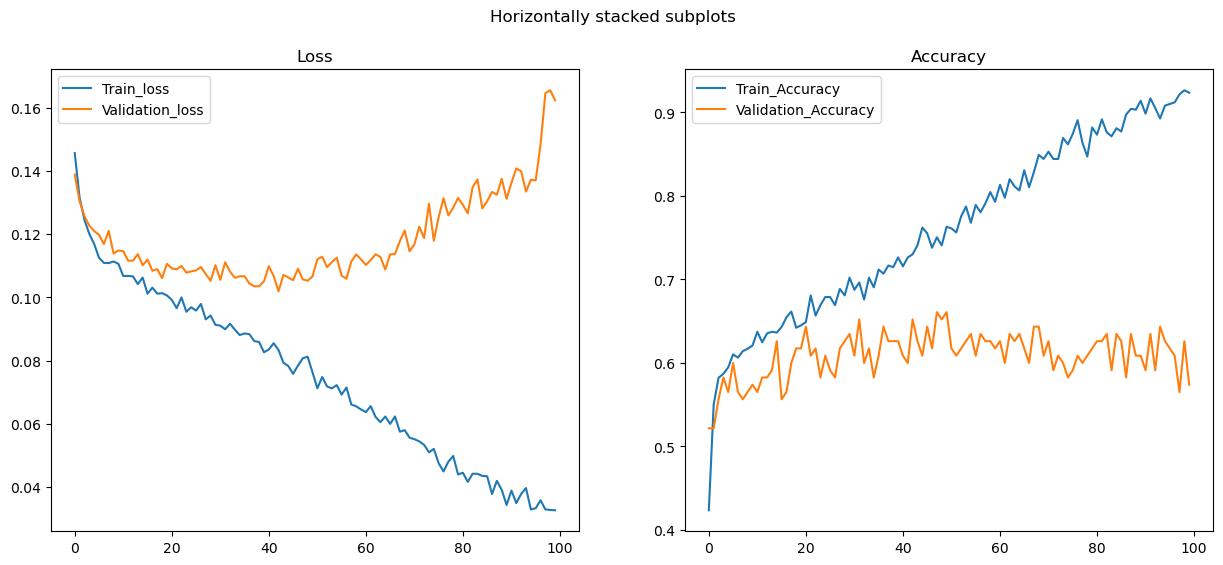

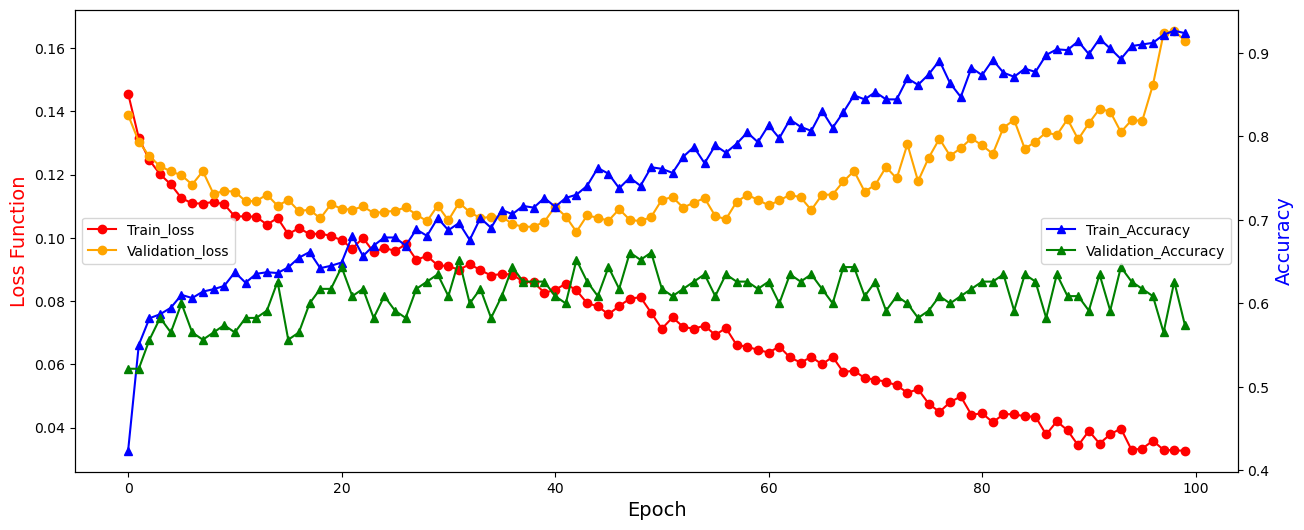

In [18]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

## Save model

In [19]:
# Save Model
NAME2 = "model_2.pt"

torch.save(modelpy, PATH+NAME2)

# Load Last Model

In [20]:
# Load the model
NAME = "model_2.pt"
modelpy = torch.load(PATH+NAME, map_location=device)
modelpy.eval()

ClassificationNet(
  (googlenet_fe): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (5): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0

## Evaluate Last Model

In [21]:
def accuracy_given_set(mm2, valid_loader, device, name="Validation"):
    # Evaluate the Validation Set
    mm2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            new_images = data[0].to(device)

            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)

            total += data[1].size(0)
            correct +=(predictions == data[1].to(device)).sum().item()
        
    print(f'Accuracy of the network on the {total} {name} instances: {100 * correct / total}%')

In [22]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:19<00:00,  6.71it/s]


Accuracy of the network on the 1034 Train instances: 89.0715667311412%


100%|██████████| 15/15 [00:02<00:00,  7.04it/s]

Accuracy of the network on the 115 Validation instances: 57.391304347826086%


## Test Predictions Last Model

In [30]:
def make_predictions(mm2, loader, device):
    # Evaluate the Validation Set
    mm2.eval()
    predictions_list = []
    name_list = []
    
    with torch.no_grad():
        for bi, data in tqdm(enumerate(loader), total=len(loader)):
            new_images = data[0].to(device)
        
            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)
        
            predictions_list.append(predictions[0].item())
            name_list.append(data[1][0])
        
    return(predictions_list, name_list)

In [31]:
pred, names = make_predictions(modelpy, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:10<00:00, 36.64it/s]


(array([0, 1, 2, 3]), array([130, 216,  33,   1], dtype=int64))

In [32]:
save_predictions_as_csv(names, pred, name="GGC_plus_clas_v02_GoogLeNet_prediction.csv")

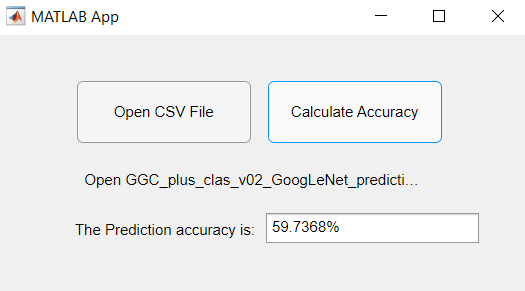

# Load Best Model

In [33]:
# Load the model
NAME = "model_2_bestModel.pt"
modelpy_bestModel = torch.load(PATH+NAME, map_location=device)
modelpy_bestModel.eval()

ClassificationNet(
  (googlenet_fe): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (5): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0

## Evaluate Best Model

In [27]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy_bestModel, train_loader, device, name="Train")
accuracy_given_set(modelpy_bestModel, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:19<00:00,  6.67it/s]


Accuracy of the network on the 1034 Train instances: 81.72147001934236%


100%|██████████| 15/15 [00:02<00:00,  7.08it/s]

Accuracy of the network on the 115 Validation instances: 66.08695652173913%


## Test Predictions Best Model

In [34]:
pred, names = make_predictions(modelpy_bestModel, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:10<00:00, 36.15it/s]


(array([0, 1, 2]), array([152, 184,  44], dtype=int64))

In [35]:
save_predictions_as_csv(names, pred, name="GGC_plus_clas_v02_GoogLeNet_best_prediction.csv")

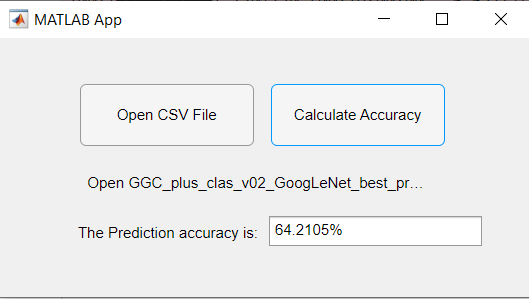